# Preparations

## CityScapes download

In [ ]:
# !pip install -q gdown

# file_id = "1MI8QsvjW0R6WDJiL49L7sDGpPWYAQB6O"
# !gdown https://drive.google.com/uc?id={file_id}

# !unzip Cityscapes.zip


## GTA5 download

In [ ]:
# !pip install -q gdown

# file_id = "1PWavqXDxuifsyYvs2PFua9sdMl0JG8AE"
# !gdown https://drive.google.com/uc?id={file_id}

# !unzip Gta5_extended.zip -d /content/Gta5_extended


## Utils

In [2]:
import numpy as np
import torch

# Define the Cityscapes colormap (labelId → RGB)
CITYSCAPES_COLORS = np.array([
    [128, 64,128], [244, 35,232], [ 70, 70, 70], [102,102,156], [190,153,153],
    [153,153,153], [250,170, 30], [220,220,  0], [107,142, 35], [152,251,152],
    [ 70,130,180], [220, 20, 60], [255,  0,  0], [  0,  0,142], [  0,  0, 70],
    [  0, 60,100], [  0, 80,100], [  0,  0,230], [119, 11, 32], [  0,  0,  0]# [ 56, 76, 70]
], dtype=np.uint8)

# Mapping labelId image to RGB image
def decode_segmap(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label_id in np.unique(mask):
        if label_id == 255:
            color_mask[mask == label_id] = CITYSCAPES_COLORS[-1]
        else:
            color_mask[mask == label_id] = CITYSCAPES_COLORS[label_id]
    return color_mask

def tensorToImage(tensor):
    """
    convert from a tensor of shape [C, H, W] where a normalization has been applied
    to an unnormalized tensor of shape [H, W, C],
    so *plt.imshow(tensorToImage(tensor))* works as expected.\n
    Intended to be used to recover the original element
    when CityScapes dataset apply the transformation
    - transform = TF.Compose([
        TF.ToTensor(),
        TF.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])])
    """
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return (tensor * std[:, None, None] + mean[:, None, None]).permute(1,2,0)

## Cityscapes implementation

In [3]:
from torch.utils.data import Dataset

import os
from torchvision.transforms import ToTensor
import cv2
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

class CityScapes(Dataset):
    def __init__(self, rootdir=".", targetdir="gtFine", imgdir="images", split="train", transform=ToTensor(), target_transform=None):
        super(CityScapes, self).__init__()

        self.rootdir = rootdir
        self.split = split
        self.targetdir = os.path.join(self.rootdir, targetdir, self.split) # ./gtFine/train/
        self.imgdir = os.path.join(self.rootdir, imgdir, self.split) # ./images/train/
        self.transform = transform
        self.target_transform = target_transform

        self.imgs_path = []
        self.targets_color_path = []
        self.targets_labelIds_path = []

        for city in os.listdir(self.imgdir): # frankfurt
            img_city_dir = os.path.join(self.imgdir, city) # ./images/train/frankfurt/
            target_city_dir = os.path.join(self.targetdir, city) # ./gtFine/train/frankfurt/

            for img_path in os.listdir(img_city_dir): # frankfurt_000000_000294_leftImg8bit.png
                if img_path.endswith(".png"):
                  self.imgs_path.append(os.path.join(img_city_dir, img_path)) # ./images/train/frankfurt/frankfurt_000000_000294_leftImg8bit.png

                  target_color_path = img_path.replace("leftImg8bit", "gtFine_color") # frankfurt_000000_000294_gtFine_color.png
                  target_labelIds_path = img_path.replace("leftImg8bit", "gtFine_labelTrainIds") # frankfurt_000000_000294_gtFine_labelTrainIds.png

                  self.targets_color_path.append(os.path.join(target_city_dir, target_color_path)) # ./gtFine/train/frankfurt/frankfurt_000000_000294_gtFine_color.png
                  self.targets_labelIds_path.append(os.path.join(target_city_dir, target_labelIds_path)) # ./gtFine/train/frankfurt/frankfurt_000000_000294_gtFine_labelTrainIds.png

    def __getitem__(self, idx):
        image = Image.open(self.imgs_path[idx]).convert('RGB')

        target_color = Image.open(self.targets_color_path[idx]).convert('RGB')
        target_labelIds = cv2.imread(self.targets_labelIds_path[idx], cv2.IMREAD_UNCHANGED)

        if self.transform is not None:
            image = self.transform(image)
            target_color = self.transform(target_color)
        if self.target_transform is not None:
            target_labelIds = self.target_transform(target_labelIds)

        return image, target_color, target_labelIds

    def __len__(self):
        return len(self.imgs_path)


## GTA5 implementation

In [4]:
from abc import ABCMeta
from dataclasses import dataclass
from typing import Tuple

class BaseGTALabels(metaclass=ABCMeta):
    pass


@dataclass
class GTA5Label:
    ID: int
    color: Tuple[int, int, int]


class GTA5Labels_TaskCV2017(BaseGTALabels):
    road = GTA5Label(ID=0, color=(128, 64, 128))
    sidewalk = GTA5Label(ID=1, color=(244, 35, 232))
    building = GTA5Label(ID=2, color=(70, 70, 70))
    wall = GTA5Label(ID=3, color=(102, 102, 156))
    fence = GTA5Label(ID=4, color=(190, 153, 153))
    pole = GTA5Label(ID=5, color=(153, 153, 153))
    light = GTA5Label(ID=6, color=(250, 170, 30))
    sign = GTA5Label(ID=7, color=(220, 220, 0))
    vegetation = GTA5Label(ID=8, color=(107, 142, 35))
    terrain = GTA5Label(ID=9, color=(152, 251, 152))
    sky = GTA5Label(ID=10, color=(70, 130, 180))
    person = GTA5Label(ID=11, color=(220, 20, 60))
    rider = GTA5Label(ID=12, color=(255, 0, 0))
    car = GTA5Label(ID=13, color=(0, 0, 142))
    truck = GTA5Label(ID=14, color=(0, 0, 70))
    bus = GTA5Label(ID=15, color=(0, 60, 100))
    train = GTA5Label(ID=16, color=(0, 80, 100))
    motocycle = GTA5Label(ID=17, color=(0, 0, 230))
    bicycle = GTA5Label(ID=18, color=(119, 11, 32))
    void = GTA5Label(ID=255, color=(0,0,0))

    list_ = [
        road,
        sidewalk,
        building,
        wall,
        fence,
        pole,
        light,
        sign,
        vegetation,
        terrain,
        sky,
        person,
        rider,
        car,
        truck,
        bus,
        train,
        motocycle,
        bicycle,
        void
    ]

    @property
    def support_id_list(self):
        ret = [label.ID for label in self.list_]
        return ret

In [11]:
from torch.utils.data import Dataset
import os
from PIL import Image

from tqdm import tqdm
# TODO: create the split
# TODO: create the label img form the colored img

class GTA5(Dataset):
    def __init__(self, rootdir, split, train_split_percent, targetdir="labels", imgdir="images", transform=None, target_transform=None):
        super(GTA5, self).__init__()

        self.rootdir = rootdir
        self.split = split
        self.targetdir = os.path.join(self.rootdir, targetdir) # ./labels
        self.imgdir = os.path.join(self.rootdir, imgdir) # ./images
        self.transform = transform
        self.target_transform = target_transform

        self.imgs_path = []
        self.targets_color_path = []
        self.targets_labelIds_path = []

        for image_file in os.listdir(self.imgdir): # 00001.png
            if image_file.endswith(".png"):
                self.imgs_path.append(os.path.join(self.imgdir, image_file)) #./images/00001.png

                target_color_path = image_file # 00001.png
                target_labelsId_path = image_file.split(".")[0]+"_labelIds.png" # labelIds_00001.png

                self.targets_color_path.append(os.path.join(self.targetdir, target_color_path)) #./labels/00001.png
                self.targets_labelIds_path.append(os.path.join(self.targetdir, target_labelsId_path)) #./labels/labelIDs_00001.png

    def create_target_img(self):
        for i, img_path in tqdm(enumerate(self.targets_color_path)):
            image_numpy = np.asarray(Image.open(img_path).convert('RGB'))

            H, W, _ = image_numpy.shape
            label_image = 255*np.ones((H, W), dtype=np.uint8)

            for label in GTA5Labels_TaskCV2017().list_:
                label_image[(image_numpy == label.color).all(axis=-1)] = label.ID

            new_img = Image.fromarray(label_image)
            new_img.save(self.targets_labelIds_path[i])

    def __getitem__(self, idx):
        image = Image.open(self.imgs_path[idx]).convert('RGB')

        target_color = Image.open(self.targets_color_path[idx]).convert('RGB')
        target_labelIds = cv2.imread(self.targets_labelIds_path[idx], cv2.IMREAD_UNCHANGED)

        if self.transform is not None:
            image = self.transform(image)
            target_color = self.transform(target_color)
        if self.target_transform is not None:
            target_labelIds = self.target_transform(target_labelIds)

        return image, target_color, target_labelIds

    def __len__(self):
        return len(self.imgs_path)


# Main part

## Cityscapes utilization

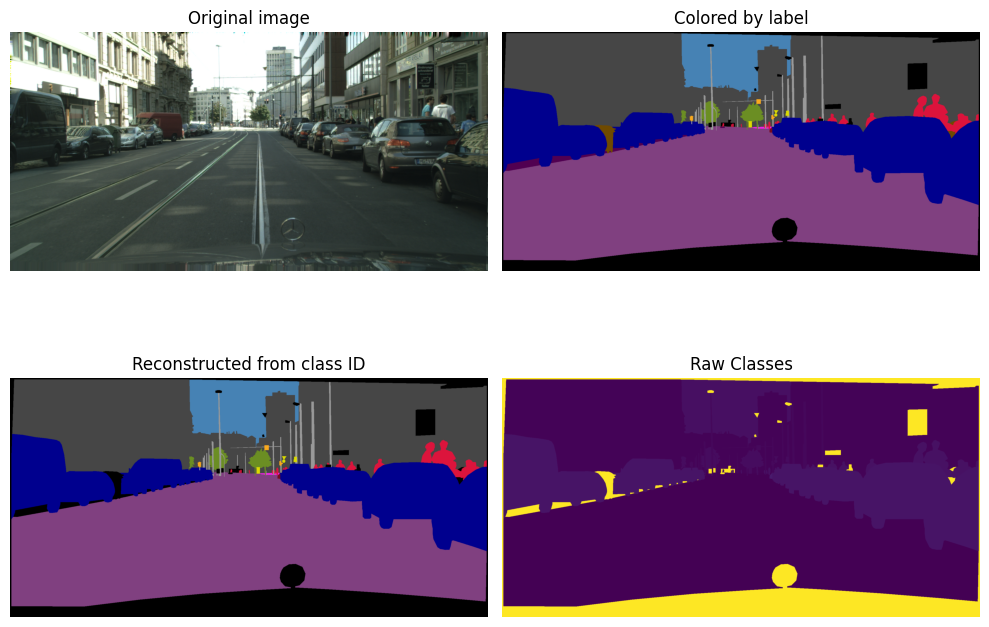

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as TF

import matplotlib.pyplot as plt

transform = TF.Compose([
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

data = CityScapes("/content/Cityscapes/Cityspaces", split="val", transform=transform)
dataloader = DataLoader(data, batch_size=8, shuffle=True)

i = 0
img_tensor, color_tensor, label = next(iter(dataloader))

img = tensorToImage(img_tensor[i])
color = tensorToImage(color_tensor[i])
decoded_from_labelId = decode_segmap(label[i])

fig, ax = plt.subplots(2,2, figsize=(10,10), layout="tight")

ax[0,0].set_title("Original image")
ax[0,0].imshow(img)
ax[0,0].axis('off')

ax[0,1].set_title("Colored by label")
ax[0,1].imshow(color)
ax[0,1].axis('off')

ax[1,0].set_title("Reconstructed from class ID")
ax[1,0].imshow(decoded_from_labelId)
ax[1,0].axis('off')

ax[1,1].set_title("Raw Classes")
ax[1,1].imshow(label[i])
ax[1,1].axis('off')

None

In [ ]:
# import shutil

# shutil.make_archive('Gta5_extended', 'zip', 'GTA5')

# from google.colab import files
# files.download('Gta5_extended.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## GTA utilization

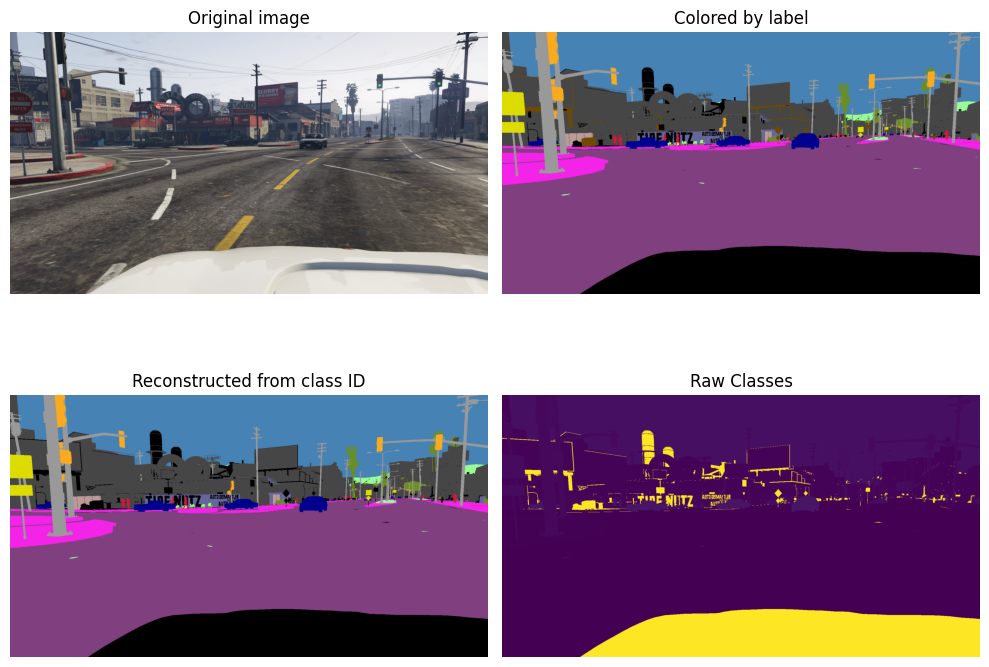

In [12]:
from torch.utils.data import DataLoader
import torchvision.transforms as TF

import matplotlib.pyplot as plt

transform = TF.Compose([
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

data = GTA5(rootdir="/content/Gta5_extended", split="train", train_split_percent=0.5, transform=transform)
dataloader = DataLoader(data, batch_size=8, shuffle=True)

i = 0
img_tensor, color_tensor, label = next(iter(dataloader))

img = tensorToImage(img_tensor[i])
color = tensorToImage(color_tensor[i])
decoded_from_labelId = decode_segmap(label[i])

fig, ax = plt.subplots(2,2, figsize=(10,10), layout="tight")

ax[0,0].set_title("Original image")
ax[0,0].imshow(img)
ax[0,0].axis('off')

ax[0,1].set_title("Colored by label")
ax[0,1].imshow(color)
ax[0,1].axis('off')

ax[1,0].set_title("Reconstructed from class ID")
ax[1,0].imshow(decoded_from_labelId)
ax[1,0].axis('off')

ax[1,1].set_title("Raw Classes")
ax[1,1].imshow(label[i])
ax[1,1].axis('off')

None